## Codice comune

Innanzitutto abbiamo preso il dataset iniziale da [qui](https://www.kaggle.com/shivamb/go-emotions-google-emotions-dataset) e con il seguente codice abbiamo: tolto i sample poco chiari, i doppioni, le colonne inutili and computed the ground truths to predict:

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords

DATASET_PATH = "go_emotions_dataset.csv" # path del dataset originale

df = pd.read_csv(DATASET_PATH)
df.drop_duplicates(subset="text", inplace=True) # remove duplicated comments
df = df[df["example_very_unclear"] == False].drop(["id","example_very_unclear"], axis="columns") # keep only clear comments and remove unnecessary columns

# indice del sentimento : gruppo di appartenenza
sent_dict = {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 2, 7: 2, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1, 15: 0, 16: 1, 
             17: 0, 18: 0, 19: 1, 20: 0, 21: 0, 22: 2, 23: 0, 24: 1, 25: 1, 26: 2, 27: 2}

def create_y(row):
    counts = np.zeros(3) # 0 = positive, 1 = negative, 2 = neutral
    indexes = np.where(row == 1)[0]
    for idx in indexes:
        counts[sent_dict[idx]] += 1
    return np.argmax(counts)

df["y"] = df.iloc[:,1:].apply(lambda x: create_y(x), axis=1) # reduce the y to predict from 28 fine-grained emotions to 3 emotions
df.drop(df.columns[1:-1], axis="columns", inplace=True)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dsant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,y
0,That game hurt.,1
2,"You do right, if you don't care then fuck 'em!",2
3,Man I love reddit.,0
4,"[NAME] was nowhere near them, he was by the Fa...",2
5,Right? Considering it’s such an important docu...,0


Runnare il codice qui sotto solo se vuoi portare tutto a lowercase:

In [2]:
df['text'] = df['text'].str.lower()
df.head()

,text,y
0,that game hurt.,1
2,"you do right, if you don't care then fuck 'em!",2
3,man i love reddit.,0
4,"[name] was nowhere near them, he was by the fa...",2
5,right? considering it’s such an important docu...,0


Runnare il codice qui sotto solo se vuoi togliere punctuation:

In [3]:
punctuation = str.maketrans('', '', string.punctuation) # dizionario con punctuation da rimuovere (la chiave è il valore ASCII del carattere)

# adding some other non-conventional unicode punctuation char codes to remove
for x,y in zip(range(8216,8232), range(8242,8248)):
    punctuation[x] = None
    punctuation[y] = None

df["text"] = df['text'].str.translate(punctuation) # lowercase and rimozione punctuation
df.head()

,text,y
0,that game hurt,1
2,you do right if you dont care then fuck em,2
3,man i love reddit,0
4,name was nowhere near them he was by the falcon,2
5,right considering its such an important docume...,0


Runnare il codice qui sotto solo se vuoi togliere le stopwords:

In [4]:
stop = stopwords.words('english')

df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop)) # rimozione stopwords
df.head()

,text,y
0,game hurt,1
2,right dont care fuck em,2
3,man love reddit,0
4,name nowhere near falcon,2
5,right considering important document know damn...,0


Runnare il codice qui sotto se vuoi togliere le parole meno frequenti:

In [4]:
word_freq = pd.Series(' '.join(df['text']).split()).value_counts()
word_freq = word_freq[(word_freq>4)]

def clean_document(document, good_words):
    return ' '.join(set(document.split(' ')).intersection(good_words))

def clean_dataset(df, word_freq):
    df.text = df.text.apply(lambda d: clean_document(d, set(word_freq.index.values)))
    
clean_dataset(df, word_freq)
df = df[df["text"] != '']
df.head()

,text,y
0,that game hurt,1
2,if right then do you dont fuck em care,2
3,man reddit love i,0
4,them he the was near name by nowhere,2
5,right i the forwards its backwards thing impor...,0


Runnare il codice qui sotto solo se vuoi effettuare lemmatization:

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(text):
    lemmas = [token.lemma_ for token in nlp(text)]
    print(text, lemmas)
    return ' '.join(lemmas)

df['text'] = df['text'].apply(lambda x: lemmatization(x))
df.head()

## Alessandro

## Davide

# BoW (Bag of Words)

<a href="https://machinelearningmastery.com/gentle-introduction-bag-words-model/">Bag of Words</a> is a way of extracting features from text, in particular we consider the frequency wherewith a single word occurs in the sentencte. 
It is called a “bag” of words, because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

## Example data
Let’s say we have a set $D$ of 2 documents:

$D$ = {“it was the best of times, it was the worst of times”, “it was the age of wisdom, it was the age of foolishness”}

Now we make a set $W$ of all of the words that are present in the set $D$:

$W$ = {“age”, “best”, “foolishness”, “it”, “of”, “the”, “times”, “was”, “wisdom”, “worst”}

And then, finally, we can create a set $X$ of document vectors (the cell $X_{ij}$ indicates how many times the word $j$ appears in the document $i$):

|   | $w_1$ | $w_2$ | $w_3$ | $w_4$ | $w_5$ | $w_6$ | $w_7$ | $w_8$ | $w_9$ | $w_{10}$ |
|---|---|---|---|---|---|---|---|---|---|---|
| $d_1$ | 0 | 1 | 0 | 2 | 2 | 2 | 2 | 2 | 0 | 1 |
| $d_2$ | 2 | 0 | 1 | 2 | 2 | 2 | 0 | 2 | 1 | 0 |

In [5]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from collections import OrderedDict

In [18]:
'''def get_data(df):
    dataset = df.to_dict('records')
    X = []
    words = set()
    for row in dataset:
        row['text'] = row['text'].split(' ')
        words = words | set(row['text'])
    words = sorted(list(words))
    index = {x[1] : x[0] for x in enumerate(words)}
    for row in dataset:
        counter = np.zeros(len(words),dtype='uint32')
        for word in row['text']:
            counter[index[word]] += 1
        X.append(counter)
    return (np.array(X), df[['y']].to_numpy(dtype='uint8').T[0])'''

"def get_data(df):\n    dataset = df.to_dict('records')\n    X = []\n    words = set()\n    for row in dataset:\n        row['text'] = row['text'].split(' ')\n        words = words | set(row['text'])\n    words = sorted(list(words))\n    index = {x[1] : x[0] for x in enumerate(words)}\n    for row in dataset:\n        counter = np.zeros(len(words),dtype='uint32')\n        for word in row['text']:\n            counter[index[word]] += 1\n        X.append(counter)\n    return (np.array(X), df[['y']].to_numpy(dtype='uint8').T[0])"

In [6]:
def get_data(df):
    comments = []
    for c in df['text']:
        comments.append(c)
    vectorizer = CountVectorizer(lowercase=False)
    X = vectorizer.fit_transform(comments)
    return vectorizer.get_feature_names(), X.toarray().astype(np.int32), df[['y']].to_numpy(dtype='uint8').T[0]  

In [7]:
def get_random_data(df, n):
    rnd_idx = np.random.choice(len(df), n, replace=False)
    df = df.iloc[rnd_idx]
    return df

In [8]:
#X,y = get_data(get_top_data(df, 20000))
feature_names, X,y = get_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, y_train.shape

((45442, 7694), (45442,))

In [10]:
def get_words(df, feature_names):
    words = []
    for row in df['text']:
        words += row.split(' ')
    return [w for w in words if w in feature_names]

df_words = pd.DataFrame(list(OrderedDict.fromkeys(get_words(df, feature_names))), columns=['word'])
df_words.head()

,word
0,that
1,game
2,hurt
3,if
4,right


## Naive Bayes

In [12]:
multi_NB_model = naive_bayes.MultinomialNB()
multi_NB_model = multi_NB_model.fit(X_train, y_train) 
sk_y = multi_NB_model.predict(X_test)

Below are shown some tables with precision, recall and accuracy for each group of sentiment

              precision    recall  f1-score   support

           0       0.66      0.71      0.68      4567
           1       0.54      0.43      0.48      2564
           2       0.54      0.56      0.55      4172

    accuracy                           0.59     11303
   macro avg       0.58      0.57      0.57     11303
weighted avg       0.59      0.59      0.59     11303

[0.71097    0.42550702 0.56495686]


<AxesSubplot:>

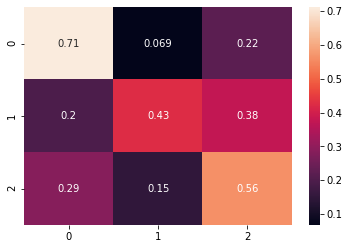

In [14]:
# with naive bayes method, wihout stop words and with text in lower case

#y_test, sk_y = np.load('C:\\Users\\dsant\\Desktop\\test1_1.npy')
#np.save('C:\\Users\\dsant\\Desktop\\test1_1.npy', [y_test, sk_y])

print(classification_report(y_test, sk_y))
cmat = confusion_matrix(y_test, sk_y, normalize='true')
print(cmat.diagonal()/cmat.sum(axis=1))
sns.heatmap(cmat,annot=True)

| Emotion | Precision | Recall | F1-score |
|---|---|---|---|
| Positive | 0.66 | 0.71 | 0.68 |
| Negative | 0.54 | 0.43 | 0.48 |
| Ambiguous | 0.54 | 0.56 | 0.55 |

              precision    recall  f1-score   support

           0       0.66      0.73      0.69      4575
           1       0.55      0.42      0.48      2571
           2       0.57      0.59      0.58      4215

    accuracy                           0.61     11361
   macro avg       0.59      0.58      0.58     11361
weighted avg       0.60      0.61      0.60     11361

[0.72655738 0.42201478 0.58647687]


<AxesSubplot:>

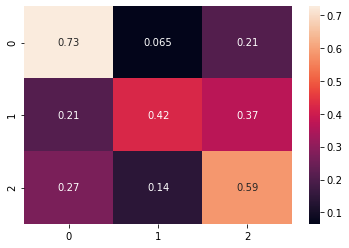

In [12]:
# with naive bayes method, with stop words and with text in lower case

np.save('C:\\Users\\dsant\\Desktop\\test1_1_2.npy', [y_test, sk_y])
#y_test, sk_y = np.load("C:\\Users\\dsant\\Desktop\\test1_2.npy")

print(classification_report(y_test, sk_y))
cmat = confusion_matrix(y_test, sk_y,normalize='true')
print(cmat.diagonal()/cmat.sum(axis=1))
sns.heatmap(cmat,annot=True)

| Emotion | Precision | Recall | F1-score |
|---|---|---|---|
| Positive | 0.66 | 0.73 | 0.69 |
| Negative | 0.55 | 0.42 | 0.48 |
| Ambiguous | 0.57 | 0.59 | 0.58 |

              precision    recall  f1-score   support

           0       0.67      0.70      0.68      4573
           1       0.54      0.45      0.49      2570
           2       0.56      0.59      0.57      4204

    accuracy                           0.60     11347
   macro avg       0.59      0.58      0.58     11347
weighted avg       0.60      0.60      0.60     11347

[0.69888476 0.44669261 0.58848716]


<AxesSubplot:>

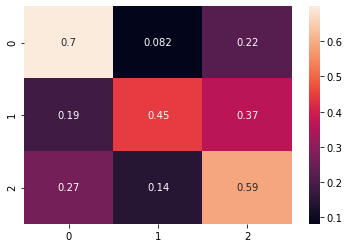

In [14]:
# with naive bayes method, with stop words and without text in lower case

#y_test, sk_y = np.load("C:\\Users\\dsant\\Desktop\\test1_3.npy")
np.save('C:\\Users\\dsant\\Desktop\\test1_1_3.npy', [y_test, sk_y])

print(classification_report(y_test, sk_y))
cmat = confusion_matrix(y_test, sk_y,normalize='true')
print(cmat.diagonal()/cmat.sum(axis=1))
sns.heatmap(cmat,annot=True)

| Emotion | Precision | Recall | F1-score |
|---|---|---|---|
| Positive | 0.67 | 0.70 | 0.68 |
| Negative | 0.54 | 0.45 | 0.49 |
| Ambiguous | 0.56 | 0.59 | 0.57 |

              precision    recall  f1-score   support

           0       0.66      0.70      0.68      4573
           1       0.57      0.43      0.49      2570
           2       0.55      0.60      0.57      4204

    accuracy                           0.60     11347
   macro avg       0.59      0.58      0.58     11347
weighted avg       0.60      0.60      0.60     11347

[0.70107151 0.42957198 0.59776403]


<AxesSubplot:>

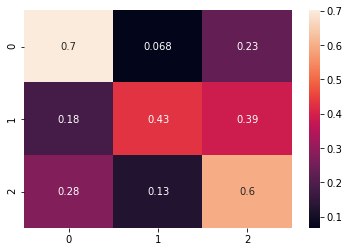

In [13]:
# with Naive Bayes method and lemmatization

np.save('C:\\Users\\dsant\\Desktop\\test1_1_4.npy', [y_test, sk_y])
#y_test, sk_y = np.load("C:\\Users\\dsant\\Desktop\\test1_3.npy")

print(classification_report(y_test, sk_y))
cmat = confusion_matrix(y_test, sk_y,normalize='true')
print(cmat.diagonal()/cmat.sum(axis=1))
sns.heatmap(cmat,annot=True)

| Emotion | Precision | Recall | Accuracy |
|---|---|---|---|
| Positive | 0.66 | 0.70 | 0.68 |
| Negative | 0.57 | 0.43 | 0.49 |
| Ambiguous | 0.55 | 0.60 | 0.57 |

## Logistic regression

In [12]:
model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model = model.fit(X_train, y_train)                  
sk_y = model.predict(X_test)

Below are shown some tables with precision, recall and accuracy for each group of sentiment

              precision    recall  f1-score   support

           0       0.71      0.68      0.69      4567
           1       0.55      0.45      0.49      2564
           2       0.56      0.65      0.60      4172

    accuracy                           0.62     11303
   macro avg       0.61      0.59      0.60     11303
weighted avg       0.62      0.62      0.61     11303

[0.67768776 0.45124805 0.64908917]


<AxesSubplot:>

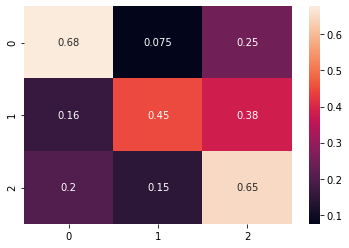

In [10]:
# with logistic regression method, wihout stop words and with text in lower case
np.save('C:\\Users\\dsant\\Desktop\\test2_1.npy', [y_test, sk_y])
print(classification_report(y_test, sk_y))
cmat = confusion_matrix(y_test, sk_y, normalize='true')
print(cmat.diagonal()/cmat.sum(axis=1))
sns.heatmap(cmat,annot=True)

| Emotion | Precision | Recall | F1-score |
|---|---|---|---|
| Positive | 0.71 | 0.68 | 0.69 |
| Negative | 0.55 | 0.45 | 0.49 |
| Ambiguous | 0.56 | 0.65 | 0.60 |

              precision    recall  f1-score   support

           0       0.71      0.70      0.70      4575
           1       0.56      0.46      0.50      2571
           2       0.57      0.65      0.61      4215

    accuracy                           0.62     11361
   macro avg       0.61      0.60      0.60     11361
weighted avg       0.62      0.62      0.62     11361

[0.69945355 0.45507585 0.6460261 ]


<AxesSubplot:>

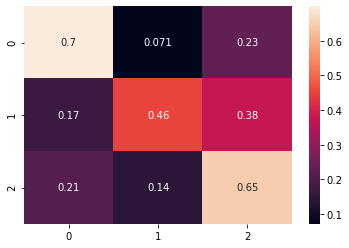

In [9]:
# with logistic regression method, with stop words and with text in lower case
np.save('C:\\Users\\dsant\\Desktop\\test2_2.npy', [y_test, sk_y])
print(classification_report(y_test, sk_y))
cmat = confusion_matrix(y_test, sk_y, normalize='true')
print(cmat.diagonal()/cmat.sum(axis=1))
sns.heatmap(cmat,annot=True)

| Emotion | Precision | Recall | Accuracy |
|---|---|---|---|
| Positive | 0.71 | 0.70 | 0.70 |
| Negative | 0.56 | 0.46 | 0.50 |
| Ambiguous | 0.57 | 0.65 | 0.61 |

              precision    recall  f1-score   support

           0       0.71      0.67      0.69      4573
           1       0.54      0.47      0.50      2570
           2       0.56      0.64      0.60      4204

    accuracy                           0.61     11347
   macro avg       0.60      0.59      0.60     11347
weighted avg       0.62      0.61      0.61     11347

[0.67133173 0.4688716  0.63725024]


<AxesSubplot:>

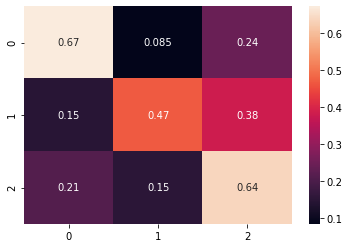

In [10]:
# with logistic regression method, with stop words and without text in lower case
np.save('C:\\Users\\dsant\\Desktop\\test2_3.npy', [y_test, sk_y])
print(classification_report(y_test, sk_y))
cmat = confusion_matrix(y_test, sk_y, normalize='true')
print(cmat.diagonal()/cmat.sum(axis=1))
sns.heatmap(cmat,annot=True)

| Emotion | Precision | Recall | F1-score |
|---|---|---|---|
| Positive | 0.71 | 0.67 | 0.69 |
| Negative | 0.54 | 0.47 | 0.50 |
| Ambiguous | 0.56 | 0.64 | 0.60 |

              precision    recall  f1-score   support

           0       0.72      0.68      0.70      4573
           1       0.57      0.47      0.51      2570
           2       0.56      0.66      0.61      4204

    accuracy                           0.62     11347
   macro avg       0.62      0.60      0.61     11347
weighted avg       0.63      0.62      0.62     11347

[0.6767986  0.46614786 0.66008563]


<AxesSubplot:>

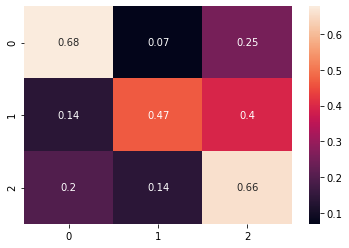

In [30]:
# with logistic regression method and lemmatization
np.save('C:\\Users\\dsant\\Desktop\\test2_4.npy', [y_test, sk_y])
print(classification_report(y_test, sk_y))
cmat = confusion_matrix(y_test, sk_y, normalize='true')
print(cmat.diagonal()/cmat.sum(axis=1))
sns.heatmap(cmat,annot=True)

| Emotion | Precision | Recall | F1-score |
|---|---|---|---|
| Positive | 0.72 | 0.68 | 0.70 |
| Negative | 0.57 | 0.47 | 0.51 |
| Ambiguous | 0.56 | 0.66 | 0.61 |

In [18]:
def get_NB_weighted_df(df, model, model_name=''):
    ret = df[:]
    for i in range(3):
        ret[f'class_{i}_weights'+f'_{model_name}' if model_name != '' else ''] = model.feature_log_prob_[i, :]
    return ret

In [13]:
def get_LR_weighted_df(df, model):
    ret = df[:]
    for i in range(model.coef_.shape[0]):
        ret[f'class_{i}_LR_importance'] = model.coef_[i,:]
    return ret

In [19]:
multi_NB_params = get_NB_weighted_df(df_words, model, 'logistic regression')

<ipython-input-18-331c4817df2e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret[f'class_{i}_weights'+f'_{model_name}' if model_name != '' else ''] = model.feature_log_prob_[i, :]


In [15]:
params = get_LR_weighted_df(df_words, model)

<ipython-input-13-c11f889c6377>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret[f'class_{i}_LR_importance'] = model.coef_[i,:]


In [16]:
params.to_csv("C:\\Users\\dsant\\Desktop\\ale4.csv")

In [20]:
multi_NB_model.feature_log_prob_.shape

(3, 7694)

In [21]:
df_words.shape

(7694, 1)

In [22]:
type(multi_NB_params)

pandas.core.frame.DataFrame

In [23]:
multi_NB_params.to_csv("C:\\Users\\dsant\\Desktop\\ale3.csv")

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1609
           1       0.56      0.43      0.49       894
           2       0.56      0.64      0.60      1497

    accuracy                           0.61      4000
   macro avg       0.60      0.59      0.59      4000
weighted avg       0.61      0.61      0.61      4000

[0.69049099 0.43064877 0.63994656]


<AxesSubplot:>

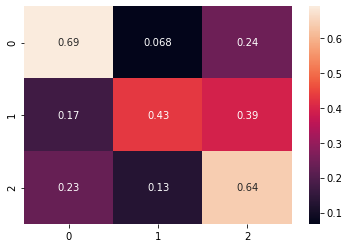

In [39]:
# with logistic regression method, with stop words and with text in lower case
y_test, sk_y = np.load("C:\\Users\\dsant\\Desktop\\test\\test2_4.npy")
print(classification_report(y_test, sk_y))
cmat = confusion_matrix(y_test, sk_y, normalize='true')
print(cmat.diagonal()/cmat.sum(axis=1))
sns.heatmap(cmat,annot=True)